In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import io
#loaded a whole bunch of stuff I might need / ended up using
data_to_load = files.upload() #asks for file from local drive
DATA = pd.read_csv(io.BytesIO(data_to_load['healthcare-dataset-stroke-data.csv'])) #imports data from csv as DATA, a pandas dataframe

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (4).csv


In [34]:
Data = DATA.to_numpy() #converts pandas data into a 2D numpy array for personal familiarity
arr = [] #creates empty array to hold indecies for numpy delete
for x in range(0,len(Data)):     #checks each sample for 
  if(Data[x][10]=='Unknown'):     #if smoking status is unknown
    arr.append(x)                 #adds index to arr for later removal
  elif(np.isnan(Data[x][9])):      #if bmi is nan
    arr.append(x)                 #adds index to arr for later removal (if not already added in previous if)
data = np.delete(Data,arr,axis=0)   #deletes unwanted samples

In [35]:
minAge = min(data[:,2])         #min and max age found for later scaling use
maxAge = max(data[:,2])
minGlu = min(data[:,8])         #min and max glucose found for later scaling use
maxGlu = max(data[:,8])
minBMI = min(data[:,9])         #min and max bmi found for later scaling use
maxBMI = max(data[:,9])
for x in range(0,len(data)):    #loop used to normalize data values
  if(data[x][1] == 'Male'):     #Male and Femal as options. Male = 0 Female = 1
    data[x][1] = 0
  else:
    data[x][1] = 1
  data[x][2] = (data[x][2]-minAge)/(maxAge-minAge)      #used min and max age to normalize ages between 0 and 1. Min = 0 Max = 1
  if(data[x,5] == 'Yes'):       #Has ever been married. Yes = 1 No = 0 
    data[x,5] = 1
  else:
    data[x,5] = 0
  if(data[x,7] == 'Rural'):     #Residence type Rural = 0 Urban = 1
    data[x,7] = 0
  else:
    data[x,7] = 1
  data[x][8] = (data[x][8]-minGlu)/(maxGlu-minGlu)      #used min and max Glu to normalize Glucose between 0 and 1. Min = 0 Max = 1
  data[x][9] = (data[x][9]-minBMI)/(maxBMI-minBMI)      #used min and max BMI to normalize BMI between 0 and 1. Min = 0 Max = 1
  if(data[x,10] == 'smokes'):                           #Smoking status: smokes =1, formerly smoked = .5, never smoked = 0, unknown = removed from data 
    data[x,10] = 1
  elif(data[x,10] == 'formerly smoked'):
    data[x,10] = 0.5
  else:
    data[x,10] = 0
data = np.delete(data,6,axis=1)     #removes employment type
data = np.delete(data,0,axis=1)     #removes patient id

In [86]:
X = data[:,0:8]       #Featurs
Y = data[:,9].astype('int')         #Labels
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = .2,random_state = 0)      #randomly split data for training and testing 80-20 ratio

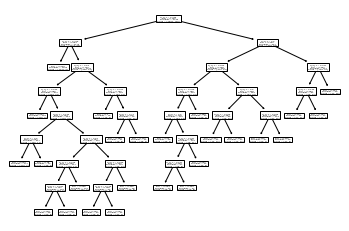

In [87]:
my_tree = DecisionTreeClassifier(max_leaf_nodes=25,max_depth=8,min_samples_leaf=30) #creates a decision tree classifier with restrictions in the form of parameters 
fig = my_tree.fit(x_train,y_train)    #fits non PCA data to the tree (data before running PCA worked better than data used after)
tree.plot_tree(fig)                   #plots the tree
plt.savefig('fig1.pdf')               #saves the tree image in pdf form

In [75]:
pca = PCA(n_components=6)       #creates PCA model with 6 components (6 found from experimentation leading to >95% explained variance)
pca.fit(X)                      #fits existing data to the model
print(pca.explained_variance_ratio_)     #prints the explained variances
X_pca=pca.transform(X)                    #transforms our data into the correct form with 6 components
x_train, x_test, y_train, y_test = train_test_split(X_pca,Y,test_size = .2,random_state = 0)    #splits the transformed data overwriting the previous X training data variables (made testing different models easier)

[0.26190674 0.25260431 0.22276527 0.11059698 0.06303019 0.04520944]


In [76]:
gnb = GaussianNB()                                  #greates Naive bayes model
pred = gnb.fit(x_train,y_train).predict(x_test)     #fits the PCA processed data to the model then populates predictions using that model for accuracy testing
print(confusion_matrix(y_test,pred))                #prints an array that contains true and false positives and negatives

[[619  35]
 [ 23   9]]


In [88]:
#SVC models were tried, but the difference in class size made the model highly inaccurate and basically unusable (only ever classified the data as one class even though parameters were set for 2)
#linear regression models had similar issues
#kmeans and k nearest neighbor both suffered from excsive false positives (model claimed patient was likely to have a stoke when they really weren't)
#Naive Bayes showed decent results, espcially after the data had been transformed by PCA
#The decision tree also showed a lot of promise and usability as parameters were being more fine tuned
#all the features were normalized between 0-1 in an effort to prevent bias in the models used. How impactful/beneficial this ultimately was is yet to be seen with this data
#string data was also converted to binary representation for similar reasons
#employment type was removed for it's complexity in normalization
#IDs were removed as they were not relevant data for the model to base predictions off of
#samples where the smoking status was unknown were removed as an assumption was made that smoking status would've been a highly important feature.
#scikit-learn documentation for the included libraries provided lots of assistance along with reference to hw from E221
#labels 0 = patient did NOT have a stroke stroke, 1 = patient had a stroke